# Pre-Scoping Analysis

## Load libraries

In [2]:
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import numpy as np
import requests
import geopandas
import pandas as pd
import geopandas as gpd
import rioxarray
import rasterio
import numpy as np
from shapely.geometry import mapping
from shapely.geometry import Polygon, MultiPolygon
import xarray as xr
from rioxarray.merge import merge_arrays
from rasterio.enums import Resampling
from xrspatial.classify import reclassify
import contextily as cx
import glob as glob
from rasterio import mask
import matplotlib.pyplot as plt
from shapely.geometry import box
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

## Global Settings

In [3]:
import datetime

def get_current_month_abbreviation():
    # Get current date
    current_date = datetime.datetime.now()

    # Get current month abbreviation
    month_abbreviation = current_date.strftime("%b")

    return month_abbreviation

## User defined input arguments

### Get user defnined inputs from proposal document

In [4]:
import requests

headers = {
  'x-api-key': 'sec_mEfBH8J51ddpgqWqjvfPtjCPrZObPwHu',
  'Content-Type': 'application/json'
}
data = {'url': 'https://c4gazureml0738433936.blob.core.windows.net/n4j/N4J-Proposal-Form_AMBOSELI_Submit%20Aug%202023.pdf'}

response = requests.post(
    'https://api.chatpdf.com/v1/sources/add-url', headers=headers, json=data)

if response.status_code == 200:
    print('Source ID:', response.json()['sourceId'])
    source_id = response.json()['sourceId']
else:
    print('Status:', response.status_code)
    print('Error:', response.text)

Source ID: src_mpORUYzDtIUv42jKMD6pK


In [5]:
headers = {
  'x-api-key': 'sec_mEfBH8J51ddpgqWqjvfPtjCPrZObPwHu',
  'Content-Type': 'application/json'
}

questions = {'client_name':'Give the organisation name. Only words not in a sectence.', 
             'usr_aoi_name':'Give the country name in which the project is in one word.',
            'usr_project_name':'Give the poject location or name of country. Only words not in a sentence.',
            'introduction':'Write an introduction for the project with information about the project area, challenges, stakeholders,  and the proposed activities for the project.',
            'land ownership':'Does the project mention anything about land ownership? If it does, write a paragraph that includes the information about land ownership and the associated risks. The following text is an example of what the paragraph should look like: The project area encompasses several land tenure systems, including private land, community or trust land, as well as public land. Implementing different interventions, such as agroforestry and regenerative agriculture, will require agreements with landowners and stakeholders. However, challenges related to land tenure, including legal complexities and conflicting interests, may pose obstacles to the projects implementation. Proactively engaging with landowners and communities will be essential to address these potential challenges. Establishing clear land use and management guidelines will also play a crucial role in reducing potential conflicts and risks associated with land tenure.'} 

answers = {}

for item in ['client_name', 'usr_aoi_name',
             'usr_project_name', 'introduction', 'land tenure']:
    data = {
        "sourceId": source_id,
        "messages": [
            {
                "role": "user",
                "content": questions.get(item),
            },
        ],
    }


    response = requests.post('https://api.chatpdf.com/v1/chats/message', headers=headers, json=data)


    if response.status_code == 200:
        print('Result:', response.json()['content'])
        answers[item] = response.json()['content']
    else:
        print('Status:', response.status_code)
        print('Error:', response.text)

Result: Organization name: African Conservation Centre (ACС)
Result: Based on the information provided in the given pages, the country in which the proposed project is located is not explicitly stated.
Result: Project location: Kenya.
Result: 1. What is the project about?
The proposed project aims to restore the Amboseli ecosystem and promote sustainable agriculture and rangeland management in the area. The Amboseli ecosystem is a fragile ecosystem threatened by fragmentation, degradation, and overgrazing. The project seeks to provide alternative land uses that provide income and livelihood opportunities through nature-based solutions, ensuring the co-existence of people and wildlife is viable and financed sustainably.

2. What are the challenges faced by the project?
The Amboseli ecosystem is under subdivision and threatened by fragmentation, degradation, and overgrazing. Biodiversity values are threatened as the subdivided land goes into incompatible land uses. The project aims to ad

### Define Paramters

In [6]:
# Main Directory
usr_parent_directory    = "/home/c4ubuntu/c4gdata/N4J/"

# Client Name 
client_name             = answers.get('client_name')

# Country Name
try:
    usr_aoi_name = answers.get('usr_aoi_name').split('.')[0]
except:
    usr_aoi_name =  answers.get('usr_aoi_name')

# Current Month
usr_month               = get_current_month_abbreviation()

# Project Name
usr_project_name        =  answers.get('usr_project_name')

In [7]:
usr_aoi_name = 'Kenya'

### Load Other  Parameters

In [8]:
def load_parameters(usr_parent_directory, usr_aoi_iso3, print_result=True):
    parms_csv = pd.read_csv(usr_parent_directory + "Data/CSV_Databases/Parameters_Updated.csv")
    try:
        dftmp = parms_csv.loc[parms_csv['Country']==usr_aoi_name]
        usr_aoi_iso3 = dftmp['ISO3_Code'].iloc[0]
        usr_aoi_cont = dftmp['Continent'].iloc[0]
        if print_result:
            print(usr_aoi_cont, usr_aoi_iso3)
        del parms_csv
        del dftmp
        return usr_aoi_iso3, usr_aoi_cont
    except:
        #print('Please check that you entered a valid ISO 3 country code.\nVisit https://www.iban.com/country-codes')
        del parms_csv
        return None, None

usr_aoi_iso3, usr_aoi_cont = load_parameters(usr_parent_directory, usr_aoi_name)

Africa KEN


In [9]:
# Project Shapefile Name
custom_aoi              = f'{usr_aoi_iso3}_AOI.shp'

## Start build project profile

In [10]:
project_profile = {}

project_profile['Client_Name'] = client_name
project_profile['Project_Location_Name'] = usr_project_name
project_profile['usr_aoi_iso3'] = usr_aoi_iso3

## Input & Output Directories

In [11]:
parent_directory = os.path.join(usr_parent_directory,"PreScoping_analysis")
proj_directory = os.path.join(parent_directory, usr_aoi_iso3)
os.makedirs(proj_directory, exist_ok=True)
data_directory = os.path.join(usr_parent_directory, 'Data')
os.makedirs(os.path.join(proj_directory,f"Products/Tables/"), exist_ok=True)

## Import data

In [12]:
active_projects = pd.read_csv(os.path.join(data_directory, 'CSV', 'active_africa_projects.csv'))

In [13]:
projects_gdf = gpd.read_file(os.path.join(data_directory, 'SHP', 'africa_projects.shp'))

# General Information

### Export introduction paragraph

In [14]:
# Extract Introduction
intro = answers.get('introduction')

# Create DataFrame
intro_df = pd.DataFrame({'ISO_3':[usr_aoi_iso3], 'Introduction':[intro]})

# Export to CSV
filename = f"{usr_aoi_iso3}_Introduction.csv"
intro_df.to_csv(os.path.join(proj_directory,f"Products/Tables/{filename}"))

# Existing Projects Map

**Import project AOI and get projects in country**

In [15]:
# Import country shapefile
project_aoi = gpd.read_file(os.path.join(data_directory, 'AOI', custom_aoi))
project_aoi = project_aoi[['geometry']]

In [16]:
# Find all projects in country
try:
    country_projects = active_projects.loc[active_projects['Country/Area'] == usr_aoi_name]
except Exception as e:
    print(e)

In [17]:
country_projects

,Unnamed: 0,ID,Name,Proponent,Project Type,AFOLU Activities,Methodology,Status,Country/Area,Estimated Annual Emission Reductions,Region,Project Registration Date,Crediting Period Start Date,Crediting Period End Date
3,1538,2338,"TIST Program in Kenya, VCS-CCB 010",Clean Air Action Corporation,Agriculture Forestry and Other Land Use,ARR,AR-AMS0007,Registered,Kenya,93619,Africa,2021-09-23,2015-02-01,2075-01-31
21,2899,1225,Kenya Agricultural Carbon Project,Vi Agroforestry Programme,Agriculture Forestry and Other Land Use,ALM,VM0017,Registered,Kenya,99004,Africa,2020-04-06,2009-07-01,2029-06-30
25,2978,899,"TIST Program in Kenya, VCS 006",Clean Air Action Corporation,Agriculture Forestry and Other Land Use,ARR,AR-AMS0001,Registered,Kenya,233275,Africa,2012-10-01,2004-01-01,2033-12-31
30,3001,737,"TIST Program in Kenya, VCS 005",Clean Air Action Corporation,Agriculture Forestry and Other Land Use,ARR,AR-AMS0001,Registered,Kenya,86694,Africa,2020-06-04,2004-01-01,2033-12-31
33,3067,562,The Kasigau Corridor REDD Project – Phase I Ru...,Wildlife Works Carbon LLC,Agriculture Forestry and Other Land Use,REDD,VM0009,Registered,Kenya,251432,Africa,2020-06-04,2005-01-01,2034-12-31
36,3150,1408,Chyulu Hills REDD+ Project,Chyulu Hills Conservation Trust,Agriculture Forestry and Other Land Use,REDD,VM0009,Registered,Kenya,1100943,Africa,2020-04-06,2013-09-19,2043-09-18
40,3275,594,"TIST Program in Kenya, VCS 001",Clean Air Action Corporation,Agriculture Forestry and Other Land Use,ARR,AR-ACM0001,Registered,Kenya,14701,Africa,2011-04-12,2004-01-01,2033-12-31
41,3276,595,"TIST Program in Kenya, VCS 002",Clean Air Action Corporation,Agriculture Forestry and Other Land Use,ARR,AR-AMS0001,Registered,Kenya,13663,Africa,2011-04-12,2004-01-01,2033-12-31
42,3277,596,"TIST Program in Kenya, VCS 003",Clean Air Action Corporation,Agriculture Forestry and Other Land Use,ARR,AR-ACM0001,Registered,Kenya,14482,Africa,2011-04-12,2004-01-01,2033-12-31
43,3278,597,"TIST Program in Kenya, VCS 004",Clean Air Action Corporation,Agriculture Forestry and Other Land Use,ARR,AR-AMS0001,Registered,Kenya,13790,Africa,2011-04-12,2004-01-01,2033-12-31


**Create table with country projects**

In [18]:
country_projects_table = country_projects[['Name', 'Proponent',
       'AFOLU Activities', 'Methodology','Estimated Annual Emission Reductions',
       'Project Registration Date','Crediting Period Start Date',
       'Crediting Period End Date' ]]

In [19]:
country_projects_table.reset_index().to_csv(os.path.join(proj_directory,f"Products/Tables/{usr_aoi_iso3}_projects_summary.csv"))

**Create Map**

/tmp/ipykernel_14600/2337878450.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_shp['centroid'] = country_shp.centroid


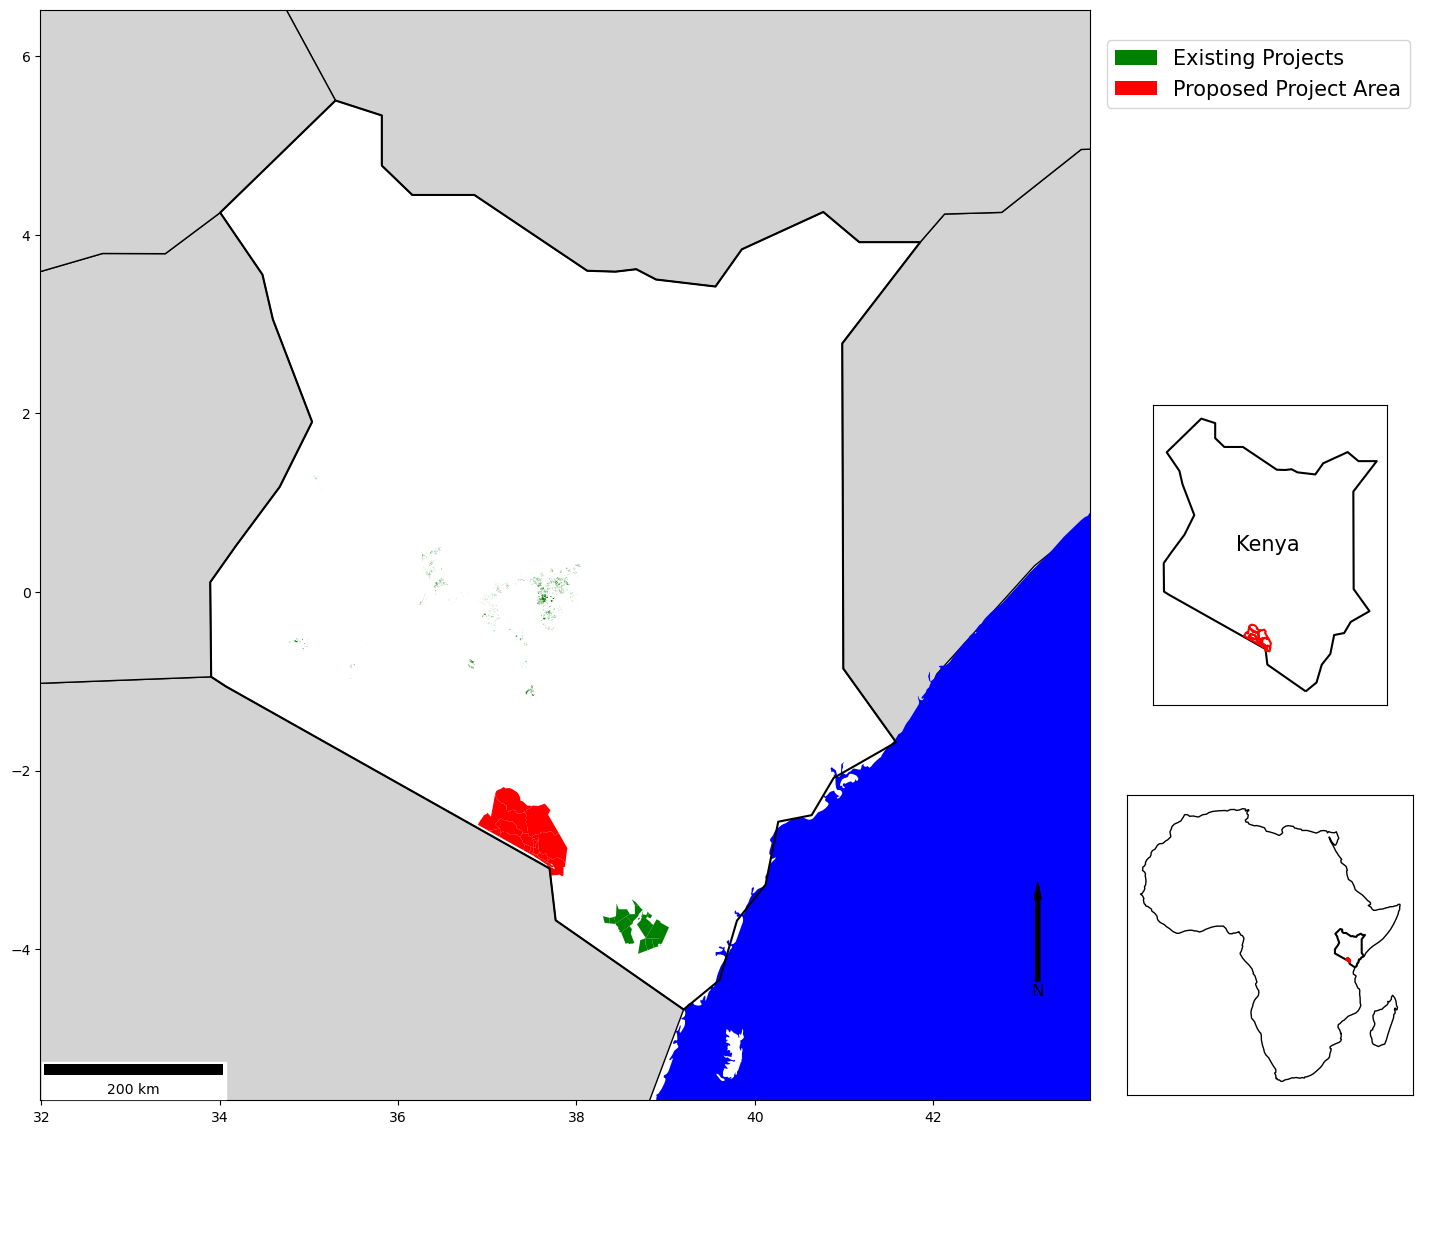

In [20]:
# Get IDs for existing projects
country_projects_ids = []
for i in country_projects.ID.unique().tolist():
    if str(i) in projects_gdf.ID.unique().tolist():
        country_projects_ids.append(i)

country_projects_ids = [str(x) for x in country_projects_ids]
country_projects_gdf = projects_gdf.set_index('ID').loc[country_projects_ids]

# Get World, Ocean and Country and Continent shapes
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ocean = gpd.read_file(os.path.join(data_directory, 'SHP', 'ne_10m_ocean.shp'))
country_shp = world.loc[world['name']==usr_aoi_name]
continent_shp = world.loc[world.continent == usr_aoi_cont].unary_union

#Check that directory for maps exists
os.makedirs(os.path.join(proj_directory,f"Products/Maps/"), exist_ok=True)

###############################################
###############################################
################# Make the map ################
###############################################
###############################################

# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0, figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])

# Calculate the xlim and ylim for the plot
xmin, ymin, xmax, ymax = country_shp.total_bounds
x_range = xmax - xmin
y_range = ymax - ymin
if x_range < y_range:
    add_dist = (y_range - x_range) / 2
    xmin -= add_dist
    xmax += add_dist
else:
    add_dist = (x_range - y_range) / 2
    ymin -= add_dist
    ymax += add_dist

# Set the plot limits
xlim = ([xmin - x_range * 0.1,  xmax + x_range * 0.1])
ylim = ([ymin - y_range * 0.1,  ymax + y_range * 0.1])
extent = box(xlim[0], ylim[0], xlim[1], ylim[1])

# Clip the world borders to the extent of the plot
world = world[world.intersects(extent)]

# Filter out the country
world = world.loc[world['name'] != usr_aoi_name]

country_shp.boundary.plot(ax=ax_map, edgecolor='black')
world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')
ocean.clip(extent).plot(ax=ax_map, facecolor='blue')

ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                 arrowprops=dict(facecolor='black', width=3, headwidth=5),
                 ha='center', va='center', fontsize=12,
                 xycoords=ax_map.transAxes)

ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

country_projects_gdf.plot(ax=ax_map, facecolor='green', label='Existing Projects')
project_aoi.plot(ax=ax_map, facecolor='red', label='Proposed Project Area')

# Manually create legend handles and labels
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, fc='green'),  # Blue rectangle for Existing Projects
    plt.Rectangle((0, 0), 1, 1, fc='red')    # Red rectangle for Proposed Project Area
]
legend_labels = ['Existing Projects', 'Proposed Project Area']

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:-1, -1])
ax_legend.set_position([0.92, 0.1, 0.1, 0.8])

# Create the legend manually using the custom handles and labels
ax_legend.legend(legend_handles, legend_labels, fontsize=15)
ax_legend.axis('off')

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='black')
project_aoi.boundary.plot(ax=ax_minimap, color='red')

ax_minimap.set_xticks([])
ax_minimap.set_yticks([])


# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap_2 = fig.add_subplot(gs[1, -1])
ax_minimap_2.set_position([0.82, 0.45, 0.2, 0.2]) 
#gpd.GeoDataFrame(geometry=[continent]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap_2, edgecolor='black')
project_aoi.boundary.plot(ax=ax_minimap_2, color='red')
country_shp['centroid'] = country_shp.centroid
country_shp.apply(lambda x: ax_minimap_2.annotate(text=x['name'], xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), ha='center', fontsize=15), axis=1)
ax_minimap_2.set_xticks([])
ax_minimap_2.set_yticks([])


# Save the figure
filename = f"{usr_aoi_iso3}_ProjectArea_CurrentProjects_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.show()

# Project Area Map

/tmp/ipykernel_83532/4181403318.py:85: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_shp['centroid'] = country_shp.centroid


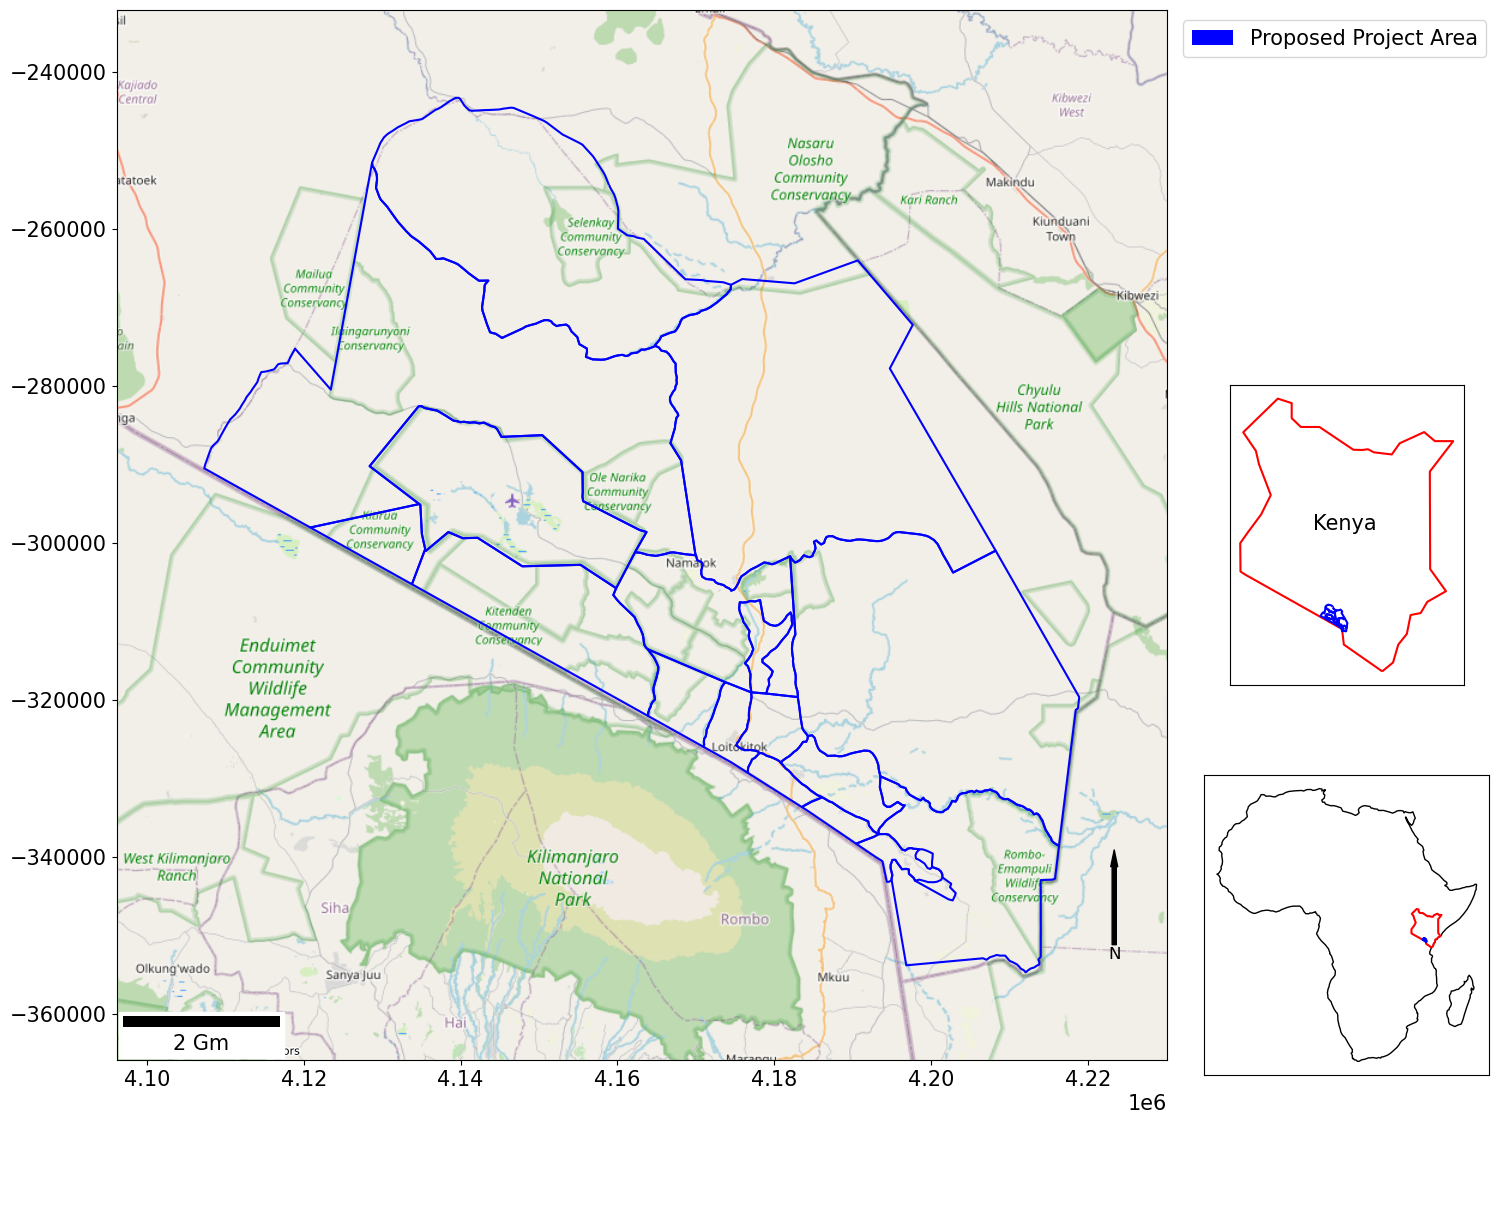

In [154]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0, figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])

# Calculate the xlim and ylim for the plot
xmin, ymin, xmax, ymax = project_aoi.to_crs('EPSG:3857').total_bounds
x_range = xmax - xmin
y_range = ymax - ymin
if x_range < y_range:
    add_dist = (y_range - x_range) / 2
    xmin -= add_dist
    xmax += add_dist
else:
    add_dist = (x_range - y_range) / 2
    ymin -= add_dist
    ymax += add_dist

# Set the plot limits
xlim = ([xmin - x_range * 0.1,  xmax + x_range * 0.1])
ylim = ([ymin - y_range * 0.1,  ymax + y_range * 0.1])
extent = box(xlim[0], ylim[0], xlim[1], ylim[1])

# Clip the world borders to the extent of the plot
world = world[world.intersects(extent)]

# Filter out the country_shp
world = world.loc[world['name'] != usr_aoi_name]

#country_shp.boundary.plot(ax=ax_map, edgecolor='black')
#world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')

ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                 arrowprops=dict(facecolor='black', width=3, headwidth=5),
                 ha='center', va='center', fontsize=12,
                 xycoords=ax_map.transAxes)

ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

#country_shp_projects_gdf.plot(ax=ax_map, facecolor='blue', label='Existing Projects')
project_aoi.to_crs('EPSG:3857').boundary.plot(ax=ax_map, color='blue', label='Proposed Project Area')
cx.add_basemap(ax_map, zoom=10, source=cx.providers.OpenStreetMap.Mapnik)

# Manually create legend handles and labels
legend_handles = [ 
    plt.Rectangle((0, 0), 1, 1, fc='blue')    # Red rectangle for Proposed Project Area
]
legend_labels = ['Proposed Project Area']

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:-1, -1])
ax_legend.set_position([0.92, 0.1, 0.1, 0.8])

# Create the legend manually using the custom handles and labels
ax_legend.legend(legend_handles, legend_labels,  fontsize=15)
ax_legend.axis('off')
#ax_legend.get_title(fontsize=12)

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='red')
project_aoi.boundary.plot(ax=ax_minimap, color='blue')

ax_minimap.set_xticks([])
ax_minimap.set_yticks([])

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap_2 = fig.add_subplot(gs[1, -1])
ax_minimap_2.set_position([0.82, 0.45, 0.2, 0.2]) 
#gpd.GeoDataFrame(geometry=[continent]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap_2, edgecolor='red')
project_aoi.boundary.plot(ax=ax_minimap_2, color='blue')
country_shp['centroid'] = country_shp.centroid
country_shp.apply(lambda x: ax_minimap_2.annotate(text=x['name'], xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), ha='center', fontsize=15), axis=1)
ax_minimap_2.set_xticks([])
ax_minimap_2.set_yticks([])

# Save the figure
filename = f"{usr_aoi_iso3}_ProjectArea_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Check projects in new project boundary

In [155]:
project_check = gpd.sjoin(project_aoi, country_projects_gdf, how='right', predicate='intersects')

In [156]:
projects_in_aoi = project_check.loc[project_check.index_left.notna()]

In [157]:
aoi_projects_ids = [int(x) for x in projects_in_aoi.reset_index().ID.unique().tolist()]

In [158]:
country_projects.reset_index(inplace=True)

In [159]:
aoi_projects = country_projects.loc[country_projects.ID.isin(aoi_projects_ids)]

In [160]:
if len(projects_in_aoi) > 0:
    project_profile['Existing Projects Status'] = 'Yes'
    project_profile['Existing Project Names'] = aoi_projects.Name.unique().tolist()
else:
    project_profile['Existing Projects Status'] = 'No'

In [161]:
project_profile

{'Client_Name': 'Organization name: African Conservation Centre (ACС)',
 'Project_Location_Name': 'Project location: Kenya.',
 'usr_aoi_iso3': 'KEN',
 'Existing Projects Status': 'No'}

# Land-Use Map

In [162]:
landcover = rioxarray.open_rasterio(os.path.join(data_directory, 'Raster','PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif'))

In [163]:
landcover = landcover.rio.clip(project_aoi.geometry, from_disk=True)

In [164]:
# Write raster to disk
landcover.rio.to_raster(os.path.join(proj_directory, f'{usr_aoi_iso3}_clipped_landcover.tif'))

In [165]:
output_path = os.path.join(proj_directory, f'{usr_aoi_iso3}_clipped_landcover.tif')

# Open the input raster file
with rasterio.open(output_path) as src:

    # Read the raster data as a numpy array
    data = src.read(1)

    # Set the no data value
    nodata = -9999

    # Create a new numpy array to store the reclassified data
    reclassified_data = np.zeros_like(data, dtype=np.uint8)

    # Define the reclassification thresholds and values
    thresholds = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100, 111, 112, 113, 114, 115, 116, 121, 122, 123, 124, 125, 126, 200]
    values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

    # Reclassify the data based on the thresholds and values
    for i in range(len(thresholds)-1):
        mask = np.logical_and(data > thresholds[i], data <= thresholds[i+1])
        reclassified_data[mask] = values[i+1]

    # Set the no data values
    reclassified_data[data == nodata] = 0

    # Set the color map
    cmap = {
        0: (0, 0, 0, 0),
        1: (255, 187, 34),
        2: (255, 255, 76),
        3: (240, 150, 255),
        4: (250, 0, 0),
        5: (180, 180, 180),
        6: (152, 245, 255),
        7: (0, 50, 200),
        8: (0, 150, 160),
        9: (250, 230, 160),
        10: (88, 72, 31),
        11: (0, 153, 0),
        12: (112, 102, 62),
        13: (0, 204, 0),
        14: (78, 117, 31),
        15: (0, 120, 0),
        16: (102, 96, 0),
        17: (141, 180, 0),
        18: (141, 116, 0),
        19: (160, 220, 0),
        20: (146, 153, 0),
        21: (100, 140, 0),
        22: (0, 0, 128)
    }
 

    # Set the output raster metadata
    kwargs = src.meta
    kwargs.update(
        dtype=rasterio.uint8,
        nodata=0,
        count=1,
        compress='lzw')

    # Write the reclassified data to a new raster file
    with rasterio.open(os.path.join(proj_directory, f'{usr_aoi_iso3}_clipped_landcover_new.tif'), 'w', **kwargs) as dst:
        dst.write(reclassified_data, 1)

        # Set the color map for the new raster file
        dst.write_colormap(1, cmap)

In [166]:
# Open raster file
landcover = rioxarray.open_rasterio(os.path.join(proj_directory, f'{usr_aoi_iso3}_clipped_landcover_new.tif'))
# Define area of interest
aoi_national = country_shp.geometry
# Clip raster to area of interest and compute
landcover = landcover.rio.clip(aoi_national.geometry, from_disk=True)

In [167]:
#Landcover Map
cmap_colors = [
    (0/255, 0/255,  0/255, 0/255),
    (255/255, 187/255, 34/255),
    (255/255, 255/255, 76/255),
    (240/255, 150/255, 255/255),
    (250/255, 0/255, 0/255),
    (180/255, 180/255, 180/255),
    (152/255, 245/255, 255/255),
    (0/255, 50/255, 200/255),
    (0/255, 150/255, 160/255),
    (250/255, 230/255, 160/255),
    (88/255, 72/255, 31/255),
    (0/255, 153/255, 0/255),
    (112/255, 102/255, 62/255),
    (0/255, 204/255, 0/255),
    (78/255, 117/255, 31/255),
    (0/255, 120/255, 0/255),
    (102/255, 96/255, 0/255),
    (141/255, 180/255, 0/255),
    (141/255, 116/255, 0/255),
    (160/255, 220/255, 0/255),
    (146/255, 153/255, 0/255),
    (100/255, 140/255, 0/255),
    (0/255, 0/255, 128/255)]


landcover_classes = {0:'No Data',
                    1:'Shrubs',
                    2:'Herbaceous vegetation',
                    3:'Cropland',
                    4:'Urban / built up',
                    5:'Bare / sparse vegetation',
                    6:'Snow and Ice',
                    7:'Permanent water bodies',
                    8:'Herbaceous wetland',
                    9:'Moss and lichen',
                    10:'Closed forest, evergreen needle leaf',
                    11:'Closed forest, evergreen, broad leaf',
                    12:'Closed forest, deciduous needle leaf',
                    13:'Closed forest, deciduous broad leaf',
                    14:'Closed forest, mixed',
                    15:'Closed forest, unknown',
                    16:'Open forest, evergreen needle leaf',
                    17:'Open forest, evergreen broad leaf',
                    18:'Open forest, deciduous needle leaf',
                    19:'Open forest, deciduous broad leaf',
                    20:'Open forest, mixed',
                    21:'Open forest, unknown',
                    22:'Open sea'}

# Calculate the area for each landcover class
x_resolution = 10  # Example pixel resolution in the x direction
y_resolution = 10  # Example pixel resolution in the y direction

pixel_area = x_resolution * y_resolution  # Calculate the area of a single pixel

# Get unique landcover classes
unique_classes = np.unique(landcover.squeeze())

land_cover = {}

land_cover_names = []

for i in unique_classes:
    # Create a mask where the land cover values are 2
    mask = np.where(landcover.squeeze() == i, 1, 0)
    pixel_count = np.count_nonzero(mask)
    class_name = landcover_classes.get(i)
    class_area = (pixel_count * 10000) // 10000
    land_cover[class_name] = class_area
    land_cover_names.append(class_name)
    print(class_name, class_area)
    
colors = np.array(cmap_colors, dtype=object)[unique_classes]

No Data 539286
Shrubs 209140
Herbaceous vegetation 186867
Cropland 61173
Urban / built up 310
Bare / sparse vegetation 3955
Permanent water bodies 41
Herbaceous wetland 927
Closed forest, deciduous broad leaf 218
Closed forest, unknown 169
Open forest, deciduous broad leaf 198
Open forest, unknown 19836


In [168]:
land_cover_names

['No Data',
 'Shrubs',
 'Herbaceous vegetation',
 'Cropland',
 'Urban / built up',
 'Bare / sparse vegetation',
 'Permanent water bodies',
 'Herbaceous wetland',
 'Closed forest, deciduous broad leaf',
 'Closed forest, unknown',
 'Open forest, deciduous broad leaf',
 'Open forest, unknown']

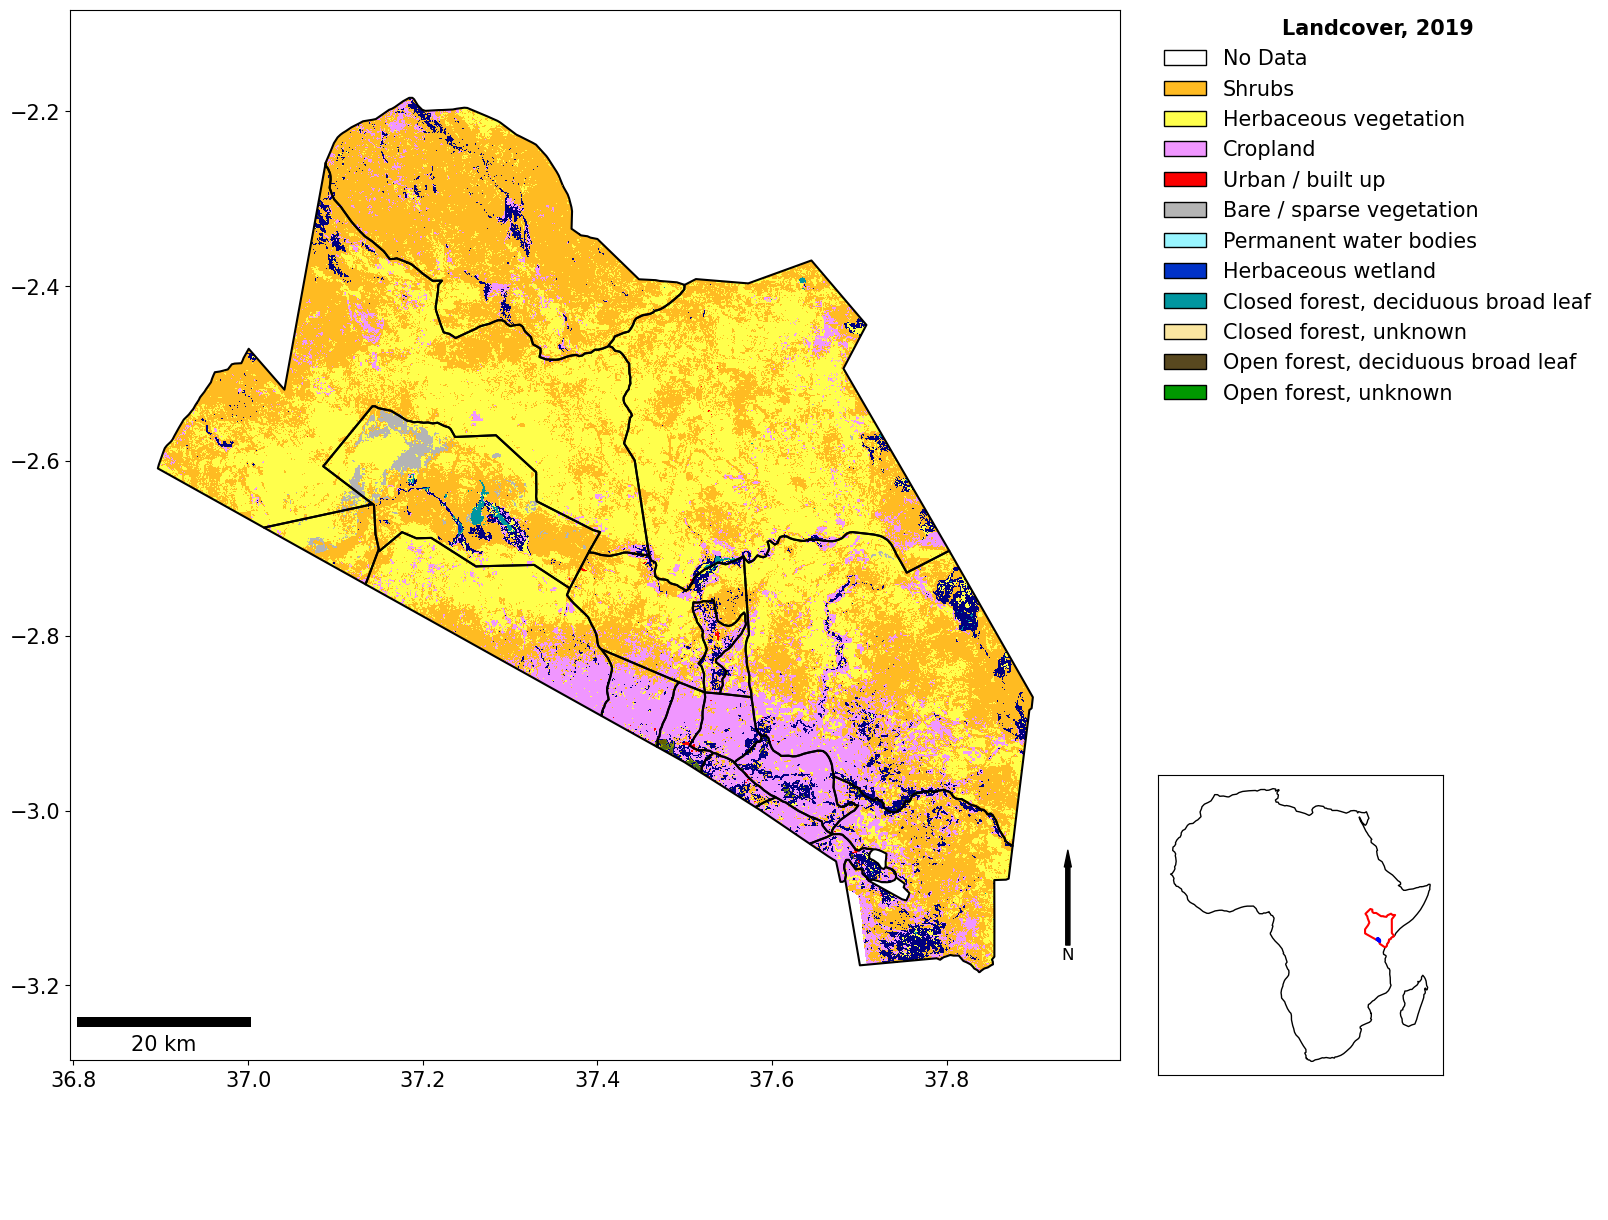

In [169]:
landcover_cmap = ListedColormap(cmap_colors)

lc_patches = [
    mpatches.Patch(facecolor=landcover_cmap(i), edgecolor='black', label=lc)
    for i, lc in enumerate(land_cover_names)]

plt.rcParams.update({'font.size': 15})

# Calculate the xlim and ylim for the plot
xmin, ymin, xmax, ymax = project_aoi.total_bounds
x_range = xmax - xmin
y_range = ymax - ymin
if x_range < y_range:
    add_dist = (y_range - x_range) / 2
    xmin -= add_dist
    xmax += add_dist
else:
    add_dist = (x_range - y_range) / 2
    ymin -= add_dist
    ymax += add_dist

# Set the plot limits
xlim = ([xmin - x_range * 0.1,  xmax + x_range * 0.1])
ylim = ([ymin - y_range * 0.1,  ymax + y_range * 0.1])
extent = box(xlim[0], ylim[0], xlim[1], ylim[1])

# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0,figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])


landcover.where(landcover != 255)[0].plot.imshow(ax=ax_map, add_colorbar=False, cmap=landcover_cmap)
project_aoi.boundary.plot(ax=ax_map, color='black')
#world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')
ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=5),
            ha='center', va='center', fontsize=12,
            xycoords=ax_map.transAxes)
ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:-1, -1])
ax_legend.set_position([1.0, 0.1, 0.1, 0.8])
legend = ax_legend.legend(handles=lc_patches, bbox_to_anchor=(1.19, 1), borderaxespad=0., title='Landcover, 2019', frameon=False, fancybox=True)
legend.get_title().set_fontweight('bold')
legend.get_title().set_fontsize(15) 
ax_legend.axis('off')

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='red')
project_aoi.boundary.plot(ax=ax_minimap, color='blue')
ax_minimap.set_xticks([])
ax_minimap.set_yticks([])

filename = f"{usr_aoi_iso3}_LandCover_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.show()

## Land Use Table

In [170]:
os.makedirs(os.path.join(proj_directory,f"Products/Tables/"), exist_ok=True)

In [171]:
landcover_classes = {0:'No Data',
                    1:'Shrubs',
                    2:'Herbaceous vegetation',
                    3:'Cropland',
                    4:'Urban / built up',
                    5:'Bare / sparse vegetation',
                    6:'Snow and Ice',
                    7:'Permanent water bodies',
                    8:'Herbaceous wetland',
                    9:'Moss and lichen',
                    10:'Closed forest, evergreen needle leaf',
                    11:'Closed forest, evergreen, broad leaf',
                    12:'Closed forest, deciduous needle leaf',
                    13:'Closed forest, deciduous broad leaf',
                    14:'Closed forest, mixed',
                    15:'Closed forest, unknown',
                    16:'Open forest, evergreen needle leaf',
                    17:'Open forest, evergreen broad leaf',
                    18:'Open forest, deciduous needle leaf',
                    19:'Open forest, deciduous broad leaf',
                    20:'Open forest, mixed',
                    21:'Open forest, unknown',
                    22:'Open sea'}

In [172]:
# Calculate the area for each landcover class
x_resolution = 10  # Example pixel resolution in the x direction
y_resolution = 10  # Example pixel resolution in the y direction

pixel_area = x_resolution * y_resolution  # Calculate the area of a single pixel

# Get unique landcover classes
unique_classes = np.unique(landcover.squeeze())

In [173]:
land_cover = {}

for i in unique_classes:
    # Create a mask where the land cover values are 2
    mask = np.where(landcover.squeeze() == i, 1, 0)
    pixel_count = np.count_nonzero(mask)
    class_name = landcover_classes.get(i)
    class_area = (pixel_count * 10000) // 10000
    land_cover[class_name] = class_area
    print(class_name, class_area)

No Data 539286
Shrubs 209140
Herbaceous vegetation 186867
Cropland 61173
Urban / built up 310
Bare / sparse vegetation 3955
Permanent water bodies 41
Herbaceous wetland 927
Closed forest, deciduous broad leaf 218
Closed forest, unknown 169
Open forest, deciduous broad leaf 198
Open forest, unknown 19836


In [174]:
land_cover_table = pd.DataFrame(land_cover, index=[0])

In [175]:
land_cover_table = land_cover_table.drop(columns='No Data')

In [176]:
land_cover_table = land_cover_table.transpose().reset_index()

In [177]:
land_cover_table = land_cover_table.rename(columns={'index':'Land Cover Class', 0:'Area (ha)'})

In [178]:
filename = f"{usr_aoi_iso3}_LandCover_Table.csv"
land_cover_table.to_csv(os.path.join(proj_directory,f"Products/Tables/{filename}"))

OSError: [Errno 16] Device or resource busy: '/home/c4ubuntu/c4gdata/N4J/PreScoping_analysis/KEN/Products/Tables/KEN_LandCover_Table.csv'

# Forest Loss map

In [ ]:
def grab_hansen(shp_aoi, variable):
    # Identify IDs of corresponding hansen data from fishnet grid
    fishnet = gpd.read_file(os.path.join(data_directory, "SHP","fishnet_Named.shp"))
    ID = gpd.sjoin(shp_aoi, fishnet, how="inner")[['Name']]

    # Convert to list
    ID = ID.Name.to_list()

    # Grab corresponding Hansen data
    data_list = []

    # Loop
    for id in ID:
        id = str(id)
        print(id)
        # Check if Hansen has been downloaded
        han = os.listdir(os.path.join(data_directory, "Hansen/"))
        han = [h for h in han if f"Hansen_GFC-2021-v1.9_treecover2000_{id}.tif" in h]
        
        if len(han) == 0:
            # Download URL
            url = f"https://storage.googleapis.com/earthenginepartners-hansen/GFC-2021-v1.9/Hansen_GFC-2021-v1.9_{variable}_{id}.tif"
            file_name = os.path.basename(requests.head(url).url)
            print(f"Downloading {file_name} from {url}")
            response = requests.get(url)
            with open(os.path.join(data_directory,"Hansen/", file_name), 'wb') as f:
                f.write(response.content)

            data = rioxarray.open_rasterio(f"{data_directory}/Hansen/Hansen_GFC-2021-v1.9_{variable}_{id}.tif", mask_and_scale=True)
            data_list.append(data)

        else:
            print("Loading...")
            data = rioxarray.open_rasterio(f"{data_directory}/Hansen/Hansen_GFC-2021-v1.9_{variable}_{id}.tif", mask_and_scale=True)
            
            data_list.append(data)

    mosaic = merge_arrays(data_list).squeeze()
    
    data_clipped = mosaic.rio.clip(shp_aoi.geometry.apply(mapping), from_disk=True,  drop=True)
    
    return(data_clipped)

In [ ]:
def load_loss(usr_aoi_iso3, aoi_national):
    if os.path.exists(f'{proj_directory}/{usr_aoi_iso3}_treeloss.tif'):
        #print('Loss exits. Loading...')
        aoi_national_treeloss = rioxarray.open_rasterio(f'{proj_directory}/{usr_aoi_iso3}_treeloss.tif', mask_and_scale=True)
    else:
        #print('Downloading and loading Loss...')     
        aoi_national_treeloss = grab_hansen(project_aoi, variable='lossyear')
        aoi_national_treeloss.rio.to_raster(f'{proj_directory}/{usr_aoi_iso3}_treeloss.tif')
    return aoi_national_treeloss

In [ ]:
def load_loss_reclass(usr_aoi_iso3, aoi_national_treeloss):
    if os.path.exists(f'{proj_directory}/{usr_aoi_iso3}_treeloss_reclass.tif'):
        #print('Reclassified Loss exits. Loading...')
        aoi_national_treeloss_reclass = rioxarray.open_rasterio(f'{proj_directory}/{usr_aoi_iso3}_treeloss_reclass.tif', mask_and_scale=True)
    else:
        #print('Downloading and loading reclassified loss...')  
        aoi_national_treeloss_reclass = reclassify(aoi_national_treeloss.squeeze(), bins=[1, np.inf],new_values=[0, 1])
        aoi_national_treeloss_reclass = aoi_national_treeloss_reclass.rio.clip(aoi_national.geometry.apply(mapping), from_disk=True, drop=True)
        aoi_national_treeloss_reclass.rio.to_raster(f'{proj_directory}/{usr_aoi_iso3}_treeloss_reclass.tif')
        #dbutils.fs.mv(f'file:/databricks/driver/{usr_aoi_iso3}_treeloss_reclass.tif', f'/mnt/fnrb/fNRB_analysis/{usr_aoi_iso3}/{usr_aoi_iso3}_treeloss_reclass.tif')
    return aoi_national_treeloss_reclass

In [ ]:
aoi_national_treeloss = load_loss(usr_aoi_iso3, project_aoi)

In [ ]:
aoi_national_treeloss_reclass = load_loss_reclass(usr_aoi_iso3, aoi_national_treeloss)

In [ ]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0,figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])

# Load and plot the tree cover raster
src = rioxarray.open_rasterio(f'{proj_directory}/{usr_aoi_iso3}_treeloss_reclass.tif')
src.where(src ==1)[0].plot.imshow(ax=ax_map, cmap='Reds_r', add_colorbar=False)

project_aoi.boundary.plot(ax=ax_map, color='black')
#world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')
ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=5),
            ha='center', va='center', fontsize=12,
            xycoords=ax_map.transAxes)
ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:-1, -1])
ax_legend.set_position([0.85, 0.1, 0.1, 0.8])
# Add the legend
legend_patch = mpatches.Patch(color='red', label='Areas of loss')
legend = ax_legend.legend(handles=[legend_patch],borderaxespad=0.,title='Forest Loss',frameon=False, fancybox=True, fontsize=15)
legend.get_title().set_fontsize(15)  # Increase the size of the legend title
legend.get_title().set_fontweight('bold')
ax_legend.axis('off')

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='red')
ax_minimap.set_xticks([])
ax_minimap.set_yticks([])


# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap_2 = fig.add_subplot(gs[1, -1])
ax_minimap_2.set_position([0.82, 0.45, 0.2, 0.2]) 
#gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap_2, edgecolor='black')
project_aoi.boundary.plot(ax=ax_minimap_2, color='red')
country_shp['centroid'] = country_shp.centroid
country_shp.apply(lambda x: ax_minimap_2.annotate(text=x['name'], xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), ha='center', fontsize=15), axis=1)
ax_minimap_2.set_xticks([])
ax_minimap_2.set_yticks([])


# Save the figure
filename = f"{usr_aoi_iso3}_WoodyLoss_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Treecover 2000 Map

In [ ]:
def load_treecover(usr_aoi_iso3, aoi_national):
    if os.path.exists(f'{proj_directory}/{usr_aoi_iso3}_2000_treecov.tif'):
        #print('Treecover exists. Loading...')
        aoi_national_treecov = rioxarray.open_rasterio(f'{proj_directory}/{usr_aoi_iso3}_2000_treecov.tif', mask_and_scale=True)
    else:
        #print('Downloading and loading Treecover...')
        aoi_national_treecov = grab_hansen(aoi_national, variable='treecover2000')
        aoi_national_treecov.rio.to_raster(f'{proj_directory}/{usr_aoi_iso3}_2000_treecov.tif')
        #dbutils.fs.mv(f'file:/databricks/driver/{usr_aoi_iso3}_2000_treecov.tif', f'/mnt/fnrb/fNRB_analysis/{usr_aoi_iso3}/{usr_aoi_iso3}_2000_treecov.tif')
    return aoi_national_treecov

In [ ]:
aoi_national_treecov = load_treecover(usr_aoi_iso3, project_aoi)

In [ ]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0,figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])



src = rioxarray.open_rasterio(f"{proj_directory}/{usr_aoi_iso3}_2000_treecov.tif")
src[0].plot.imshow(ax=ax_map, cmap='Greens', add_colorbar=False)

project_aoi.boundary.plot(ax=ax_map, color='black')
#world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')

ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=5),
            ha='center', va='center', fontsize=12,
            xycoords=ax_map.transAxes)

ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:-1, -1])
ax_legend.set_position([0.86, 0.1, 0.1, 0.8])
# Define the class names and colors
classes = [('0-30%', 'lightgreen'), ('30-60%', 'mediumseagreen'), ('60-100%', 'darkgreen')]

# Add the legend
legend_patches = []
for i, (label, color) in enumerate(classes):
    legend_patches.append(mpatches.Patch(color=color, label=label))

legend = ax_legend.legend(handles=legend_patches, borderaxespad=0.,title='Percent Treecover',frameon=False, fancybox=True, fontsize=15)
legend.get_title().set_fontweight('bold')
legend.get_title().set_fontsize(15)  # Increase the size of the legend title

ax_legend.axis('off')

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='red')
ax_minimap.set_xticks([])
ax_minimap.set_yticks([])

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap_2 = fig.add_subplot(gs[1, -1])
ax_minimap_2.set_position([0.82, 0.45, 0.2, 0.2]) 
#gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap_2, edgecolor='black')
project_aoi.boundary.plot(ax=ax_minimap_2, color='red')
country_shp['centroid'] = country_shp.centroid
country_shp.apply(lambda x: ax_minimap_2.annotate(text=x['name'], xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), ha='center', fontsize=15), axis=1)
ax_minimap_2.set_xticks([])
ax_minimap_2.set_yticks([])

# Save the figure
filename = f"{usr_aoi_iso3}_Woody2000_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Agri 2003

In [ ]:
def check_coverage(file, aoi, filename):
    # Open the raster datasets
    dataset1 = rasterio.open(file)

    # Get the extent of the datasets
    x_min1, y_min1, x_max1, y_max1 = dataset1.bounds

    # Define your area of interest (AOI)
    minx, miny, maxx, maxy = aoi.total_bounds

    # Check if the datasets overlap the AOI
    if x_max1 < minx or x_min1 > maxx or y_max1 < miny or y_min1 > maxy:
        print("Dataset 1 does not overlap the AOI.")
    else:
        print("Dataset 1 overlaps the AOI.")
        filename.append(file)
    # Close the datasets
    dataset1.close()
    return filename

In [ ]:
for year in ['2003', '2019']:
    filename = []
    files = glob.glob(os.path.join(data_directory, 'Raster','Cropland', f'*{year}.tif'))    
    for file in files:
        crop_file = check_coverage(file, project_aoi, filename)
    print(crop_file[0])
    # Open the raster dataset
    dataset = rasterio.open(crop_file[0])

    # Define your area of interest (AOI) coordinates
    aoi_x_min, aoi_y_min, aoi_x_max, aoi_y_max = project_aoi.total_bounds

    # Convert AOI coordinates to dataset pixel coordinates
    window = dataset.window(aoi_x_min, aoi_y_min, aoi_x_max, aoi_y_max)
    window_transform = rasterio.windows.transform(window, dataset.transform)

    # Read the data within the AOI window
    data = dataset.read(window=window)
    
    # Create the output raster file
    output_profile = dataset.profile
    output_profile.update(width=window.width, height=window.height, transform=window_transform)

    with rasterio.open(os.path.join(proj_directory, f'merged_cropland_{year}.tif'), 'w', **output_profile) as dst:
        dst.write(data)

    # Close the dataset
    dataset.close()

In [ ]:
import rasterio
from rasterio.mask import mask

# Open the raster dataset
dataset = rasterio.open(os.path.join(proj_directory, f'merged_cropland_2003.tif'))

# Make sure the AOI polygon has the same CRS as the raster dataset
aoi = project_aoi.to_crs(dataset.crs)

# Extract the geometry of the AOI polygon
aoi_geometry = gpd.GeoDataFrame(geometry=[aoi.unary_union]).geometry.values[0]

# Clip the raster dataset using the AOI polygon
clipped_data, clipped_transform = mask(dataset, shapes=[aoi_geometry], crop=True)

# Update the profile of the clipped dataset
clipped_profile = dataset.profile
clipped_profile.update(width=clipped_data.shape[2],
                      height=clipped_data.shape[1],
                      transform=clipped_transform)

# Create the output raster file
with rasterio.open(os.path.join(proj_directory, 'clipped_cropland_2003.tif'), 'w', **clipped_profile) as dst:
    dst.write(clipped_data)

# Close the dataset
dataset.close()

In [ ]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0,figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])

# Load and plot the tree cover raster
src = rioxarray.open_rasterio(os.path.join(proj_directory,'clipped_cropland_2003.tif'))
src.where(src ==1)[0].plot.imshow(ax=ax_map, cmap='Purples', add_colorbar=False)

project_aoi.boundary.plot(ax=ax_map, color='black')
#world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')
ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=5),
            ha='center', va='center', fontsize=12,
            xycoords=ax_map.transAxes)
ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:-1, -1])
ax_legend.set_position([0.85, 0.1, 0.1, 0.8])
# Add the legend
legend_patch = mpatches.Patch(color='purple', label='Cropland')
legend = ax_legend.legend(handles=[legend_patch],borderaxespad=0.,title='Cropland 2003',frameon=False, fancybox=True, fontsize=15)
legend.get_title().set_fontsize(15)  # Increase the size of the legend title
legend.get_title().set_fontweight('bold')
ax_legend.axis('off')

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='red')
ax_minimap.set_xticks([])
ax_minimap.set_yticks([])

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap_2 = fig.add_subplot(gs[1, -1])
ax_minimap_2.set_position([0.82, 0.45, 0.2, 0.2]) 
#gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap_2, edgecolor='black')
project_aoi.boundary.plot(ax=ax_minimap_2, color='red')
country_shp['centroid'] = country_shp.centroid
country_shp.apply(lambda x: ax_minimap_2.annotate(text=x['name'], xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), ha='center', fontsize=15), axis=1)
ax_minimap_2.set_xticks([])
ax_minimap_2.set_yticks([])

# Save the figure
filename = f"{usr_aoi_iso3}_Cropland_2003_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.close()

# Agri 2019

In [ ]:
# Open the raster dataset
dataset = rasterio.open(os.path.join(proj_directory, f'merged_cropland_2019.tif'))

# Make sure the AOI polygon has the same CRS as the raster dataset
aoi = project_aoi.to_crs(dataset.crs)

# Extract the geometry of the AOI polygon
aoi_geometry = gpd.GeoDataFrame(geometry=[aoi.unary_union]).geometry.values[0]

# Clip the raster dataset using the AOI polygon
clipped_data, clipped_transform = mask(dataset, shapes=[aoi_geometry], crop=True)

# Update the profile of the clipped dataset
clipped_profile = dataset.profile
clipped_profile.update(width=clipped_data.shape[2],
                      height=clipped_data.shape[1],
                      transform=clipped_transform)

# Create the output raster file
with rasterio.open(os.path.join(proj_directory, 'clipped_cropland_2019.tif'), 'w', **clipped_profile) as dst:
    dst.write(clipped_data)

# Close the dataset
dataset.close()

In [ ]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0,figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])

# Load and plot the tree cover raster
src = rioxarray.open_rasterio(os.path.join(proj_directory, 'clipped_cropland_2019.tif'))
src.where(src ==1)[0].plot.imshow(ax=ax_map, cmap='Purples', add_colorbar=False)

project_aoi.boundary.plot(ax=ax_map, color='black')
#world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')
ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=5),
            ha='center', va='center', fontsize=12,
            xycoords=ax_map.transAxes)
ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:-1, -1])
ax_legend.set_position([0.85, 0.1, 0.1, 0.8])
# Add the legend
legend_patch = mpatches.Patch(color='purple', label='Cropland')
legend = ax_legend.legend(handles=[legend_patch],borderaxespad=0.,title='Cropland 2019',frameon=False, fancybox=True, fontsize=15)
legend.get_title().set_fontsize(15)  # Increase the size of the legend title
legend.get_title().set_fontweight('bold')
ax_legend.axis('off')

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='red')
ax_minimap.set_xticks([])
ax_minimap.set_yticks([])

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap_2 = fig.add_subplot(gs[1, -1])
ax_minimap_2.set_position([0.82, 0.45, 0.2, 0.2]) 
#gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap_2, edgecolor='black')
project_aoi.boundary.plot(ax=ax_minimap_2, color='red')
country_shp['centroid'] = country_shp.centroid
country_shp.apply(lambda x: ax_minimap_2.annotate(text=x['name'], xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), ha='center', fontsize=15), axis=1)
ax_minimap_2.set_xticks([])
ax_minimap_2.set_yticks([])


# Save the figure
filename = f"{usr_aoi_iso3}_Cropland_2019_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.close()

# Population​

In [ ]:
# Open the raster dataset
dataset = rasterio.open(os.path.join(data_directory, 'Raster','Population', 'ppp_2020_1km_Aggregated.tif'))

# Make sure the AOI polygon has the same CRS as the raster dataset
aoi = project_aoi.to_crs(dataset.crs)

# Extract the geometry of the AOI polygon
aoi_geometry = gpd.GeoDataFrame(geometry=[aoi.unary_union]).geometry.values[0]

# Clip the raster dataset using the AOI polygon
clipped_data, clipped_transform = mask(dataset, shapes=[aoi_geometry], crop=True)

# Update the profile of the clipped dataset
clipped_profile = dataset.profile
clipped_profile.update(width=clipped_data.shape[2],
                      height=clipped_data.shape[1],
                      transform=clipped_transform)

# Create the output raster file
with rasterio.open(os.path.join(proj_directory, f'{usr_aoi_iso3}_population_ken.tif'), 'w', **clipped_profile) as dst:
    dst.write(clipped_data)

# Close the dataset
dataset.close()

In [ ]:
import matplotlib.colors as colors

# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0, figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])

# Load and plot the population raster
src = rioxarray.open_rasterio(os.path.join(proj_directory, f'{usr_aoi_iso3}_population_ken.tif'))
src.where(src != src.rio.nodata, np.nan).squeeze().plot.imshow(ax=ax_map, cmap='viridis', add_colorbar=False)

project_aoi.boundary.plot(ax=ax_map, color='black')
# world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')
ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                 arrowprops=dict(facecolor='black', width=3, headwidth=5),
                 ha='center', va='center', fontsize=12,
                 xycoords=ax_map.transAxes)
ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

# Define the legend plot in the middle row of the grid
ax_legend = fig.add_subplot(gs[1, -1])
ax_legend.set_position([0.82, 0.52, 0.05, 0.4])  # Adjust the position as needed

# Normalize the colorbar scale (logarithmic scale in this example)
vmin = 1e-0  # Adjust the vmin value as needed
vmax = src.max()
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# Plot the colorbar legend
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), cax=ax_legend)
cbar.set_label('Population (People per m2)')

# Adjust the font size of the colorbar labels
cbar.ax.tick_params(labelsize=12)

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='red')

ax_minimap.set_xticks([])
ax_minimap.set_yticks([])

## Save map
filename = f"{usr_aoi_iso3}_Population_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.close()

# Check Activity Applicability

In [ ]:
methodologies = pd.read_csv(os.path.join(data_directory, 'CSV', 'verra_methodologies_ver0.csv'), index_col=[0])

**Check methodologies according to land use**

In [ ]:
landcover_classes_new = {'Shrubs':'Shrubs',
                    'Herbaceous vegetation':'Herbaceous vegetation',
                    'Cropland':'Cropland',
                    'Urban / built up':'Urban',
                    'Bare / sparse vegetation':'Bare',
                    'Snow and Ice':'Snow and Ice',
                    'Permanent water bodies':'Permanent water bodies',
                    'Herbaceous wetland':'Wetlands',
                    'Moss and lichen':'Moss and lichen',
                    'Closed forest, evergreen needle leaf':'Forest',
                    'Closed forest, evergreen, broad leaf':'Forest',
                    'Closed forest, deciduous needle leaf':'Forest',
                    'Closed forest, deciduous broad leaf':'Forest',
                    'Closed forest, mixed':'Forest',
                    'Closed forest, unknown':'Forest',
                    'Open forest, evergreen needle leaf':'Forest',
                    'Open forest, evergreen broad leaf':'Forest',
                    'Open forest, deciduous needle leaf':'Forest',
                    'Open forest, deciduous broad leaf':'Forest',
                    'Open forest, mixed':'Forest',
                    'Open forest, unknown':'Forest',
                    'Open sea':'Open sea'}

In [ ]:
land_covers_renamed = land_cover_table.copy()

for old_name in land_cover_table['Land Cover Class'].unique():
    new_name = landcover_classes_new.get(old_name)
    land_covers_renamed = land_covers_renamed.replace(old_name, new_name)

**Get methodologies applicable to land cover in area**

In [ ]:
project_profile['Eligible_Methodologies_Landcover'] = []

for landc in land_covers_renamed['Land Cover Class'].unique():
    if landc in methodologies.Eligible_Area.unique():
        project_profile['Eligible_Methodologies_Landcover'].append({landc:list(methodologies.loc[methodologies['Eligible_Area'] == landc].VCS_Code.unique())})
        print({landc:list(methodologies.loc[methodologies['Eligible_Area'] == landc].VCS_Code.unique())})

In [ ]:
project_profile

**Get activities that are applicable to land cover in area**

In [ ]:
eligible_methodologies = methodologies.loc[methodologies['Eligible_Area'].isin(land_covers_renamed['Land Cover Class'].unique())]

In [ ]:
activ = {}
for i in eligible_methodologies['VCS_Code'].unique():
    activities = eligible_methodologies.loc[eligible_methodologies.VCS_Code == i]['Activity_type'].unique()
    activ[i] = list(activities)
    print(i, activities)

In [ ]:
project_profile['Eligible_Activies'] = activ

In [ ]:
project_profile

# Available Methodology Table

In [ ]:
methdology_descriptive = pd.read_csv(os.path.join(data_directory, 'CSV', 'verra_methodologies_ver0_Descriptive.csv'), index_col=[0])

In [ ]:
meth_codes = []

for i in project_profile.get('Eligible_Methodologies_Landcover'):
    for item in list(i.values()):
        if len(item) == 1:
            item = item[0]
            meth_codes.append(item)
        else:
            for x in range(len(item)):
                new = item[x]
                meth_codes.append(new)

In [ ]:
meth_codes

In [ ]:
project_methodology_descriptive = methdology_descriptive.loc[methdology_descriptive.VCS_Code.isin(meth_codes)]

In [ ]:
# Filter rows with 'Eligible' Criterion_Type
eligible_df = project_methodology_descriptive[project_methodology_descriptive['Criterion_Type'] == 'Eligibility']
eligible_df = eligible_df.rename(columns={'Criterion': 'Eligibility'}).drop('Criterion_Type', axis=1)
eligible_df = eligible_df[['VCS_Code','Activity_type','Eligibility']]
eligible_df = eligible_df.drop_duplicates()

# Filter rows with 'Ineligible' Criterion_Type
ineligible_df = project_methodology_descriptive[project_methodology_descriptive['Criterion_Type'] == 'Ineligibility']
ineligible_df = ineligible_df.rename(columns={'Criterion': 'Ineligibility'}).drop('Criterion_Type', axis=1)
ineligible_df = ineligible_df[['VCS_Code','Activity_type','Ineligibility']]
ineligible_df = ineligible_df.drop_duplicates() 

In [ ]:
result_df = pd.merge(eligible_df, ineligible_df, on=['VCS_Code', 'Activity_type'], how='right')
result_df.loc[result_df['Eligibility'].duplicated(), 'Eligibility'] = np.NaN

result_df.loc[result_df['Ineligibility'].duplicated(), 'Ineligibility'] = np.NaN

result_df = result_df.set_index(['VCS_Code','Activity_type']).dropna(how='all')

filename = f"{usr_aoi_iso3}_Methodology_Table.csv"
result_df.to_csv(os.path.join(proj_directory,f"Products/Tables/{filename}"))

### 9: Risk: Copy from report or get input

In [ ]:
# INPUT: specify which risk bullets in the csv file pertain to this project - use the index numbers, e.g. [1,2,3]
INPUT_RISKS = [4,5,6,7]
ALL_RISKS = False

dfRisks = pd.read_csv(os.path.join(data_directory, 'CSV', 'Risks_bullets.csv'))
dfRisksFiltered = dfRisks[ dfRisks['Risk_id'].isin(INPUT_RISKS) ] if not ALL_RISKS else dfRisks

filename = usr_aoi_iso3 + '_Risks_bullets.csv'
dfRisksFiltered.to_csv(os.path.join(proj_directory,f"Products/Tables/{filename}"), index=False)

### 10: Leakage: get input

In [186]:
# INPUT: specify which leakage bullets in the csv file pertain to this project - use the index numbers, e.g. [1,2,3]
INPUT_LEAKAGE = [1,2,3]
ALL_LEAKAGE = False

dfLeakage = pd.read_csv(os.path.join(data_directory, 'CSV', 'Leakage_bullets.csv'))
dfLeakageFiltered = dfLeakage[ dfLeakage['Leakage_id'].isin(INPUT_LEAKAGE) ] if not ALL_LEAKAGE else dfLeakage

###
dfLeakageFiltered["New_Description"] = ''
for index,row in dfLeakageFiltered.iterrows():
    data = {
        "sourceId": source_id,
        "messages": [
            {
                "role": "user",
                "content": f"Please rewrite the following paragraph on a specific carbon leakage risk associated with the project by adding any information within the document that expands upon the information in the paragraph. If there is no information, simply keep the paragraph as is. Respond with only the rewritten paragraph. The paragraph: {row['Description']}",
            },
        ],
    }


    response = requests.post('https://api.chatpdf.com/v1/chats/message', headers=headers, json=data)


    if response.status_code == 200:
        print('Original: ', row['Description'], '\n')
        print('Result:', response.json()['content'], '\n')
        print('\n')
        newDescription = response.json()['content'].split("ewritten paragraph:")[-1].strip()
        newDescription = row['Description'] if row['Description'][:10] not in newDescription else newDescription
        dfLeakageFiltered.loc[index, 'New_Description'] = newDescription
    else:
        print('Status:', response.status_code)
        print('Error:', response.text)
print(dfLeakageFiltered['New_Description'])
###

filename = usr_aoi_iso3 + '_Leakage_bullets.csv'
dfLeakageFiltered.to_csv(os.path.join(proj_directory,f"Products/Tables/{filename}"), index=False)

Original:  If the project leads to the displacement of agricultural activities, there is a risk that farmers may expand their cultivation into nearby forested or other sensitive areas, resulting in deforestation and increased emissions. 

Result:  Rewritten paragraph: If the project leads to the displacement of agricultural activities, there is a risk of leakage into incompatible land uses, which may result in deforestation and increased emissions. This risk is being addressed by gazettement of the subdivision and strengthening of land governance frameworks in the target area on sustainable rangeland management. 



Original:  The implementation of the project may cause the movement of economic activities, such as agriculture, settlement or logging, from the project area to nearby regions. This could lead to indirect land-use changes and associated emissions elsewhere. 

Result:  I'm sorry, I misunderstood your request earlier. Here is the rewritten paragraph:

The implementation of th

### 11: Additionality: get input

### 12: Carbon numbers: get input